<a href="https://colab.research.google.com/github/ChamsToure/wave_energy_farm/blob/main/wave_energy_farm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General information

Wave energy is a rapidly advancing and promising renewable energy source that holds great potential for addressing the challenges of global warming and climate change. However, optimizing energy output in large wave farms presents a complex problem due to the expensive calculations required to account for hydrodynamic interactions between wave energy converters (WECs). Developing a fast and accurate surrogate model is crucial to overcome these challenges. In light of this, we have compiled an extensive WEC dataset that includes 54,000 and 9,600 configurations involving 49 and 100 WECs, coordination, power, q-factor, and total farm power output. The dataset was derived from a study published at the GECCO conference and received the prestigious Best Paper award. We want to acknowledge the support of the University of Adelaide Phoenix HPC service in conducting this research. For more details, please refer to the following link: https://dl.acm.org/doi/abs/10.1145/3377930.3390235.

## Features
The dataset includes 4 CSV files for 49 and 100 wave energy converters based on Perth and Sydney wave scenarios. The main goal is predicting the total power output of the wave farm based on the coordination of WECs (X1, Y1, X2, Y2,..., Xn, Yn). As the second plan, predicting the power output of each converter in the wave farm can be interesting.

* X and Y - coordinates
* Power - individual power
* total power - total power of all the WECs
* qW - q-factor

## Findings
There are many duplicates in the dataset (4540).

## Goal
* Predicting the total power output of the wave farm based on the coordination of WECs
* Predicting the power ouput of each converter in the wave farm

## Candidates for inaccuracy
* To small dataset -> need more data
* Not the right regression model -> Test many different regression models and measure their accuracy

## Potential Problems
* Cannot inference based on geodata from only 4 locations, especially with a relatively small dataset.
* In what timeframe was the data collected? Becuase you cannot predict the total power over the year if it is also dependent of the seasons
* Why are there so many duplicates?

## Instances
Each instance represents the coordination of wave energy converters in a wave farm plus the total power output and individual power of each converter and q-factor.

## Source
https://archive.ics.uci.edu/dataset/882/large-scale+wave+energy+farm
Neshat, Mehdi, Bradley Alexander, Nataliia Y. Sergiienko, and Markus Wagner. "Optimisation of large wave farms using a multi-strategy evolutionary framework." In Proceedings of the 2020 Genetic and Evolutionary Computation Conference, pp. 1150-1158. 2020.
Link to research: https://dl.acm.org/doi/abs/10.1145/3377930.3390235.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = pd.read_csv("/content/drive/MyDrive/Ai/WEC_Perth_100.csv")

## Preprocessing

In [6]:
dataset.shape

(7277, 302)

In [7]:
dataset.head()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,Power93,Power94,Power95,Power96,Power97,Power98,Power99,Power100,qW,Total_Power
0,1000.0,0.0,946.08,37.42,889.67,74.76,832.02,112.10,1250.0,1.0,...,98711.68,102872.82,100743.44,99259.87,98909.46,101388.37,101025.35,98676.66,0.75,7257985.04
1,800.0,0.0,746.04,37.38,689.81,74.79,632.43,111.97,1200.0,0.0,...,96351.38,102253.02,101744.20,99482.45,99304.59,101953.23,100878.42,99508.49,0.74,7103374.61
2,600.0,0.0,545.98,37.50,489.87,74.95,432.52,112.15,650.0,0.0,...,96985.29,102472.80,101757.63,99429.45,98709.14,101312.44,100979.86,99024.16,0.76,7335380.64
3,600.0,0.0,546.09,37.41,489.70,74.76,432.35,111.90,800.0,0.0,...,76823.85,88005.41,98779.92,100260.30,98744.25,101144.58,100835.43,98915.38,0.75,7187769.87
4,600.0,0.0,545.95,37.52,489.69,74.99,432.46,112.16,800.0,0.0,...,98195.95,102874.16,100256.15,99221.12,98969.54,101389.77,100924.02,98796.00,0.75,7260222.61


### Remove Duplicates

In [5]:
dataset = dataset.drop_duplicates()

In [9]:
dataset.shape

(2737, 302)

### Check for null values

In [10]:
#Check how many null values are in the entire dataset
dataset.isnull().sum().sum()

0

## Analysis

In [11]:
columns = list(dataset)

### Check for outliers

In [12]:
dataset.describe()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,Power93,Power94,Power95,Power96,Power97,Power98,Power99,Power100,qW,Total_Power
count,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.00000,2737.000000,...,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2.737000e+03
mean,352.430815,28.443796,376.587603,48.513548,390.824538,67.395784,382.368316,100.883800,748.81297,31.299488,...,88784.392488,94574.215331,97805.710833,97620.391436,97511.043405,98655.269839,98920.618290,97713.614468,0.721995,6.959157e+06
std,293.777257,97.276123,271.069835,59.577117,282.745074,45.932165,299.046854,57.995795,285.37046,73.050856,...,10396.969817,7717.499315,6250.371796,5975.969268,5045.909333,6408.359410,4689.778147,3966.695051,0.020921,1.998767e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,34236.100000,32447.850000,30658.290000,35208.350000,29411.690000,36525.750000,42148.330000,33879.920000,0.630000,6.099480e+06
25%,129.200000,0.000000,146.150000,37.390000,89.980000,65.990000,32.640000,98.430000,600.00000,0.000000,...,76698.160000,87986.780000,98477.180000,98429.200000,98614.520000,98350.170000,98118.470000,96904.240000,0.710000,6.806309e+06
50%,200.000000,0.000000,316.740000,37.490000,324.570000,74.880000,432.240000,112.070000,661.08000,0.000000,...,95014.870000,97237.470000,98785.020000,99601.280000,98840.130000,101312.440000,100905.720000,98796.000000,0.720000,6.941249e+06
75%,600.000000,0.000000,546.040000,37.550000,489.820000,75.010000,514.460000,112.240000,1000.00000,40.990000,...,98339.870000,102029.820000,101089.720000,100267.940000,99017.440000,101438.470000,101027.360000,98959.650000,0.740000,7.129514e+06
max,1400.000000,1353.550000,1400.000000,1277.640000,1414.000000,698.010000,1400.000000,1035.090000,1413.39000,910.420000,...,103541.860000,104047.690000,104403.690000,104206.780000,103678.570000,102543.340000,102219.050000,101692.770000,0.760000,7.364528e+06


In [6]:
dataset["Total_Power"].describe()

count    2.737000e+03
mean     6.959157e+06
std      1.998767e+05
min      6.099480e+06
25%      6.806309e+06
50%      6.941249e+06
75%      7.129514e+06
max      7.364528e+06
Name: Total_Power, dtype: float64

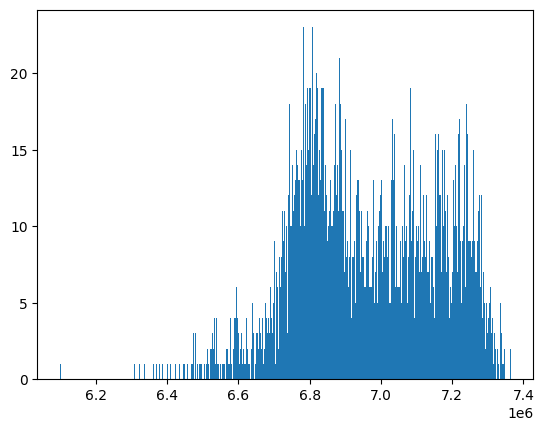

In [10]:
graph = plt.hist(x = dataset["Total_Power"], bins=500)

# Train models to predict Total_Power output of wave energy farms based on coordinates

## Drop the power columns for individual WECs and qW

In [7]:
dataset_copy = dataset.copy(deep=True)

In [8]:
for num in range(1, 101):
    dataset_copy.drop(f"Power{num}", axis=1, inplace=True)

In [9]:
dataset_copy.drop("qW", inplace=True, axis=1)

In [14]:
dataset_copy.shape

(2737, 201)

In [15]:
dataset.shape

(2737, 302)

In [16]:
y = dataset_copy["Total_Power"]
X = dataset_copy.drop("Total_Power", axis=1)

In [21]:
X.head()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,X96,Y96,X97,Y97,X98,Y98,X99,Y99,X100,Y100
0,1000.0,0.0,946.08,37.42,889.67,74.76,832.02,112.10,1250.0,1.0,...,432.02,1312.10,1200.0,1200.0,1146.08,1237.42,1089.67,1274.76,1032.02,1312.10
1,800.0,0.0,746.04,37.38,689.81,74.79,632.43,111.97,1200.0,0.0,...,232.43,1311.97,800.0,1200.0,746.04,1237.38,689.81,1274.79,632.43,1311.97
2,600.0,0.0,545.98,37.50,489.87,74.95,432.52,112.15,650.0,0.0,...,432.52,1312.15,1000.0,1200.0,945.98,1237.50,889.87,1274.95,832.52,1312.15
3,600.0,0.0,546.09,37.41,489.70,74.76,432.35,111.90,800.0,0.0,...,832.35,1311.90,1200.0,1200.0,1146.09,1237.41,1089.70,1274.76,1032.35,1311.90
4,600.0,0.0,545.95,37.52,489.69,74.99,432.46,112.16,800.0,0.0,...,432.46,1312.16,1200.0,1200.0,1145.95,1237.52,1089.69,1274.99,1032.46,1312.16


## Create train and test set

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2 ,random_state=42)

## Try Decision Tree Regressor
It is more powerful for nonlinear relationships in data

In [23]:
tree_reg_1 = DecisionTreeRegressor(max_depth=2,random_state=42).fit(X_train, y_train)
tree_reg_2 = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_train)

In [ ]:
tree_reg_1.score(X_test, y_test)

0.24867754203147185

In [ ]:
tree_reg_2.score(X_test, y_test)

0.44036272433181334

In [ ]:
cross_vals = -cross_val_score(tree_reg_1, X,y, scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
pd.Series(cross_vals).describe()

count        10.000000
mean     173455.032255
std       11567.575123
min      157648.456309
25%      164704.534676
50%      171671.588416
75%      182107.010265
max      190399.689784
dtype: float64

## Try Random Forest Regressor

In [ ]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train).score(X_test,y_test)

0.7172245433317017

In [ ]:
cross_vals_forest = cross_val_score(RandomForestRegressor(), X,y,cv=5)
cross_vals_forest

array([0.7835241 , 0.7567162 , 0.68311678, 0.65717309, 0.64243909])

## Conclusion
Random forest model looks the most promising to predict the total_power

# Train models to predict the power of individual wave energy converters

In [19]:
dataset.head()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,Power93,Power94,Power95,Power96,Power97,Power98,Power99,Power100,qW,Total_Power
0,1000.0,0.0,946.08,37.42,889.67,74.76,832.02,112.10,1250.0,1.0,...,98711.68,102872.82,100743.44,99259.87,98909.46,101388.37,101025.35,98676.66,0.75,7257985.04
1,800.0,0.0,746.04,37.38,689.81,74.79,632.43,111.97,1200.0,0.0,...,96351.38,102253.02,101744.20,99482.45,99304.59,101953.23,100878.42,99508.49,0.74,7103374.61
2,600.0,0.0,545.98,37.50,489.87,74.95,432.52,112.15,650.0,0.0,...,96985.29,102472.80,101757.63,99429.45,98709.14,101312.44,100979.86,99024.16,0.76,7335380.64
3,600.0,0.0,546.09,37.41,489.70,74.76,432.35,111.90,800.0,0.0,...,76823.85,88005.41,98779.92,100260.30,98744.25,101144.58,100835.43,98915.38,0.75,7187769.87
4,600.0,0.0,545.95,37.52,489.69,74.99,432.46,112.16,800.0,0.0,...,98195.95,102874.16,100256.15,99221.12,98969.54,101389.77,100924.02,98796.00,0.75,7260222.61


In [10]:
individual_wec_data = dataset.copy(deep=True)

In [11]:
individual_wec_data.columns

Index(['X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3', 'X4', 'Y4', 'X5', 'Y5',
       ...
       'Power93', 'Power94', 'Power95', 'Power96', 'Power97', 'Power98',
       'Power99', 'Power100', 'qW', 'Total_Power'],
      dtype='object', length=302)

## Prepare the data
Change the dataframe, so that we have the x,y coordinates and the power for each WEC in each row.

In [12]:
individual_wec_data.drop(columns=['Total_Power', 'qW'],axis=1, inplace=True)

In [13]:
individual_wec_data.columns

Index(['X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3', 'X4', 'Y4', 'X5', 'Y5',
       ...
       'Power91', 'Power92', 'Power93', 'Power94', 'Power95', 'Power96',
       'Power97', 'Power98', 'Power99', 'Power100'],
      dtype='object', length=300)

### Transform to individual WECs

In [14]:
def to_individual_WEC(dataset):
    new_dataset = {"X":[], "Y":[], "Power":[]}
    for num in range(0, len(dataset)):
        current_row = dataset.iloc[num]
        for index in range(1,101):
            new_dataset["X"].append(current_row.loc[f"X{index}"])
            new_dataset["Y"].append(current_row.loc[f"Y{index}"])
            new_dataset["Power"].append(current_row.loc[f"Power{index}"])

    new_dataset = pd.DataFrame(new_dataset)
    return new_dataset

In [15]:
individual_wec_data = to_individual_WEC(individual_wec_data)

In [16]:
individual_wec_data.shape

(273700, 3)

In [17]:
individual_wec_data.drop_duplicates(inplace=True)

In [18]:
y = individual_wec_data["Power"]
X = individual_wec_data.drop("Power", axis=1)

In [25]:
individual_wec_data.shape

(273555, 3)

### Create train and test set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2 ,random_state=42)

### Test with Decision Tree Regressor

In [107]:
dtr = DecisionTreeRegressor(max_depth=5).fit(X_train,y_train)

In [108]:
dtr.score(X_test,y_test)

0.8179964931411378

In [109]:
cvs_dtr = cross_val_score(DecisionTreeRegressor(), X,y,cv=5)

In [110]:
cvs_dtr

array([0.8420308 , 0.8458494 , 0.84369502, 0.83539277, 0.83827556])

### Test with Random Forest Regressor

In [111]:
rtr = RandomForestRegressor().fit(X_train,y_train)

In [112]:
rtr.score(X_test,y_test)

0.8547784601685058

In [113]:
cvs_rtr = cross_val_score(RandomForestRegressor(), X,y,cv=5)

In [114]:
cvs_rtr

array([0.85452133, 0.8592236 , 0.85717353, 0.84866646, 0.84995573])

## Conclusion
And again the random forest model makes the best predictions. And it is more accurate to predict individual WECs than the entire farm.

# Training a neural net

In [20]:
import tensorflow as tf

In [21]:
X_tensor = tf.convert_to_tensor(X)
y_tensor = tf.convert_to_tensor(X)

In [37]:
X.shape

(273555, 2)

In [132]:
y.shape

(273555,)

In [22]:
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_train_tensor = tf.convert_to_tensor(y_train)
y_test_tensor = tf.convert_to_tensor(y_test)

In [30]:
X_train_tensor.shape

TensorShape([218844, 2])

In [31]:
X_train_tensor.shape[1:]

TensorShape([2])

In [32]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train_tensor.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 2)                 5         
 on)                                                             
                                                                 
 dense (Dense)               (None, 50)                150       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5306 (20.73 KB)
Trainable params: 5301 (20.71 KB)
Non-trainable params: 5 (24.00 Byte)
_____________________

In [58]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer,metrics=["RootMeanSquaredError",tf.keras.metrics.MeanAbsolutePercentageError(),tf.keras.metrics.R2Score()])
norm_layer.adapt(X_train_tensor)

In [ ]:
%%time
history = model.fit(X_train_tensor, y_train_tensor, epochs=20,validation_data=(X_test_tensor, y_test_tensor))

In [60]:
mse_test, rmse_test = model.evaluate(X_test_tensor, y_test_tensor)

1710/1710 [==============================] - 4s 3ms/step - loss: 69161744.0000 - root_mean_squared_error: 8316.3545 - mean_absolute_percentage_error: 9.5958 - r2_score: 0.8234


ValueError: ignored

In [49]:
mse_test

69899032.0

In [50]:
rmse_test

8360.564453125

In [61]:
model.evaluate(X_test_tensor, y_test_tensor)

1710/1710 [==============================] - 4s 2ms/step - loss: 69161744.0000 - root_mean_squared_error: 8316.3545 - mean_absolute_percentage_error: 9.5958 - r2_score: 0.8234


[69161744.0, 8316.3544921875, 9.595788955688477, 0.8234137296676636]

In [57]:
X_new = X_test_tensor[:3]
y_pred = model.predict(X_new)

1/1 [==============================] - 0s 82ms/step


In [58]:
y_pred

array([[90670.05 ],
       [43477.277],
       [71901.16 ]], dtype=float32)

In [60]:
abs(y_pred - y_test_tensor[:3])

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[  818.376875  , 40969.256875  , 17593.536875  ],
       [46374.39265625,  6223.51265625, 29599.23265625],
       [17950.51375   , 22200.36625   ,  1175.35375   ]])>

In [71]:
X_test_tensor[:3]

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[1346.22,  237.63],
       [   0.  ,  300.  ],
       [1137.96,  496.43]])>

In [ ]:
history.history

In [72]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Power]')
  plt.legend()
  plt.grid(True)

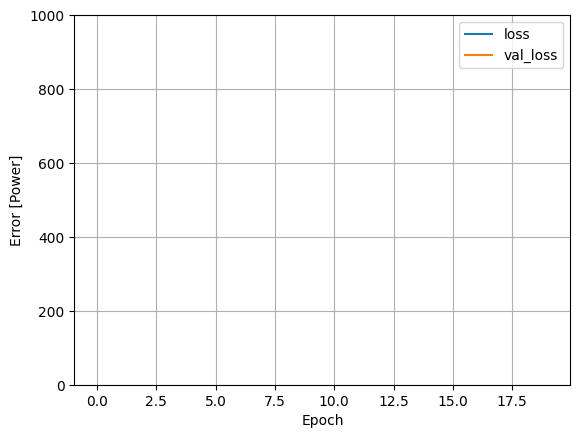

In [73]:
plot_loss(history)

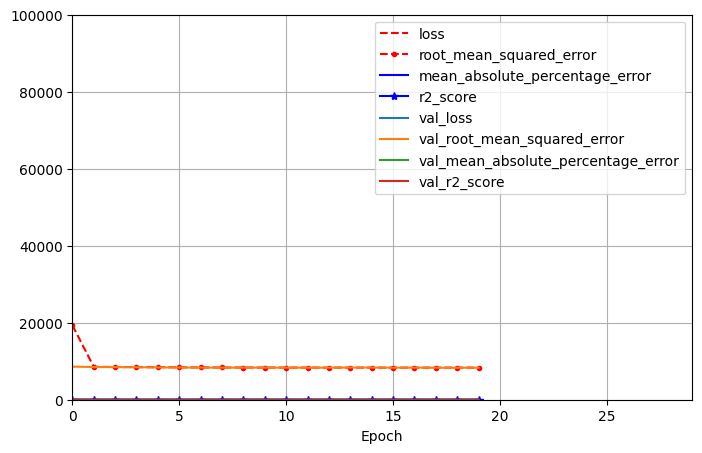

In [76]:
pd.DataFrame(history.history).plot(
figsize=(8, 5), xlim=[0, 29], ylim=[0, 100000], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [140]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train_tensor.shape[1:])
model2 = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)])

In [141]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer,metrics=["RootMeanSquaredError",tf.keras.metrics.MeanAbsolutePercentageError(),tf.keras.metrics.R2Score()])
norm_layer.adapt(X_train_tensor)

In [143]:
history = model.fit(X_train_tensor, y_train_tensor, epochs=30,validation_data=(X_test_tensor, y_test_tensor))

Epoch 1/30
6839/6839 [==============================] - 25s 4ms/step - loss: 78270040.0000 - root_mean_squared_error: 8847.0352 - mean_absolute_percentage_error: 10.4469 - r2_score: 0.7990 - val_loss: 77300696.0000 - val_root_mean_squared_error: 8792.0811 - val_mean_absolute_percentage_error: 10.3884 - val_r2_score: 0.8028
Epoch 2/30
6839/6839 [==============================] - 25s 4ms/step - loss: 77935384.0000 - root_mean_squared_error: 8828.1016 - mean_absolute_percentage_error: 10.4154 - r2_score: 0.7999 - val_loss: 77480112.0000 - val_root_mean_squared_error: 8802.2783 - val_mean_absolute_percentage_error: 10.1683 - val_r2_score: 0.8023
Epoch 3/30
6839/6839 [==============================] - 25s 4ms/step - loss: 77554744.0000 - root_mean_squared_error: 8806.5166 - mean_absolute_percentage_error: 10.3790 - r2_score: 0.8008 - val_loss: 76389840.0000 - val_root_mean_squared_error: 8740.1279 - val_mean_absolute_percentage_error: 10.2859 - val_r2_score: 0.8051
Epoch 4/30
6839/6839 [===

In [23]:
%pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 39.9 MB/s eta 0:00:00


In [24]:
import keras_tuner as kt

Using TensorFlow backend


In [36]:
def model_builder(hp):

  model = tf.keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="mean_absolute_error",
                metrics=['RootMeanSquaredError',tf.keras.metrics.R2Score(),"mean_absolute_error"])
  return model

In [37]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("val_r2_score", direction="max"),
                     max_epochs=20,
                     factor=3,
                    overwrite=True,
                     directory='./tuner',
                     project_name='intro_to_kt')

In [38]:
tuner.search(X_train_tensor, y_train_tensor, epochs=20, validation_data=(X_test_tensor, y_test_tensor))


Trial 30 Complete [00h 08m 04s]
val_r2_score: 0.8178933262825012

Best val_r2_score So Far: 0.8190782070159912
Total elapsed time: 01h 30m 57s


In [46]:
best_models = tuner.get_best_models(num_models=2)

In [51]:
best_model1 = best_models[0]
best_model2 = best_models[1]

In [52]:
best_model2.evaluate(X_test_tensor, y_test_tensor)

1710/1710 [==============================] - 4s 2ms/step - loss: 6385.4541 - root_mean_squared_error: 8412.0078 - r2_score: 0.8183 - mean_absolute_error: 6385.4541


[6385.4541015625, 8412.0078125, 0.818329930305481, 6385.4541015625]

In [53]:
best_model1.evaluate(X_test_tensor, y_test_tensor)

1710/1710 [==============================] - 4s 2ms/step - loss: 6376.5039 - root_mean_squared_error: 8394.6660 - r2_score: 0.8191 - mean_absolute_error: 6376.5039


[6376.50390625, 8394.666015625, 0.8190782070159912, 6376.50390625]

# Summary
The Random Forest Regressor had the highest r2_score with 0.85. Even the neural net with hypertuning couldn't beat.